# Freemarket Code Challenge

**Covers:**
1) Network effect from `Transfers`
2) Fuzzy standardisation of Beneficiaries & Remitters for flow size


In [40]:
%load_ext autoreload
%autoreload 2

import os, sys
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath('Code Test'))
from network import build_flow_pairs, participant_metrics, top_participants
from cleaning import standardise_counterparty_names, aggregate_flows
from viz import bar_top_series, plot_network

data_path = 'data/Test for Data Science role.xlsx'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load all tables
# Returns a dict of dataframes with keys: client, accounts, deposits, withdrawals, transfers
sheets = ['Client', 'Accounts', 'Deposits', 'Withdrawals', 'Transfers']
dfs = {s.lower(): pd.read_excel(data_path, sheet_name=s, header=1) for s in sheets}

# Normalise column names
for k, df in dfs.items():
    # Drop columns that are entirely NaN
    df = df.dropna(axis=1, how='all')
    # df.columns = (df.columns.str.strip().str.lower())
    df.columns = (df.columns
                  .str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True)
                  .str.lower()
                 )
    dfs[k] = df

In [3]:
# List all columns by table

for k,v in dfs.items():
    print(k, v.shape, list(v.columns))

client (44, 12) ['hub_spot_deal_id', 'group_name', 'group_country_incorp', 'company_name', 'company_country_incorp', 'deal_stage', 'state', 'risk_rating', 'pod', 'vertical', 'segment', 'industry']
accounts (55, 3) ['account_id', 'status', 'hub_spot_deal_id']
deposits (2268, 10) ['deposit_id', 'account_id', 'london_value_date', 'currency', 'amount', 'normalised_amount', 'deposit_origin', 'deposit_remitter_name', 'deposit_fee_normalised', 'unnamed: 10']
withdrawals (5868, 9) ['withdrawal_id', 'account_id', 'london_value_date', 'currency', 'amount', 'normalised_amount', 'beneficiary_bank_country', 'beneficiary_name', 'withdrawal_fee_normalised']
transfers (2452, 10) ['transfer_id', 'london_created_date', 'sender_account_id', 'recipient_account_id', 'currency', 'amount', 'is_inter_entity_transfer', 'normalised_amount', 'reciever_fee_normalised', 'sender_fee_normalised']


In [50]:
# assign dataframe name to each table
clients_df = dfs['client']
accounts_df = dfs['accounts']
deposits_df = dfs['deposits'].iloc[:, :-1]
withdrawals_df = dfs['withdrawals']
transfers_df = dfs['transfers']

## 1) Network effect

In [5]:
flow_pairs = build_flow_pairs(dfs['transfers'])
flow_pairs.sort_values('total_value', ascending=False).head()

,source_id,destination_id,transfer_count,total_value
62,16472,16627,399,8.764210e+08
45,14854,14669,197,1.647358e+08
69,16627,16472,165,6.125971e+07
3,14440,14445,57,6.105975e+07
81,16914,14669,155,5.416830e+07


In [6]:
participants = participant_metrics(flow_pairs)
top_p = top_participants(participants, 20)
top_p.head(10)

,participant_id,unique_destinations,unique_sources,total_sent,total_received,unique_counterparties,has_two_way_flow,interaction_profile
12,14462,8.0,9.0,2.979422e+07,3.397851e+07,17.0,True,Hub
34,16627,7.0,6.0,8.065332e+07,9.481957e+08,13.0,True,Hub
3,14445,8.0,5.0,3.807054e+07,7.538979e+07,13.0,True,Hub
31,16472,7.0,4.0,9.217713e+08,6.305111e+07,11.0,True,Broker
9,14459,6.0,5.0,3.028822e+06,1.037999e+07,11.0,True,Hub
2,14440,1.0,5.0,6.105975e+07,3.243213e+07,6.0,True,Broker
23,14857,3.0,3.0,6.319220e+06,1.276058e+06,6.0,True,Regular Member
0,14400,2.0,3.0,1.631523e+07,6.513042e+07,5.0,False,Regular Member
17,14669,1.0,4.0,4.561214e+05,2.651978e+08,5.0,False,Regular Member
7,14456,2.0,3.0,2.308977e+04,2.620894e+05,5.0,True,Regular Member


In [7]:
participants['interaction_profile'].value_counts()

interaction_profile
Peripheral Member    34
Regular Member       14
Hub                   4
Broker                3
Name: count, dtype: int64

<Figure size 640x480 with 0 Axes>

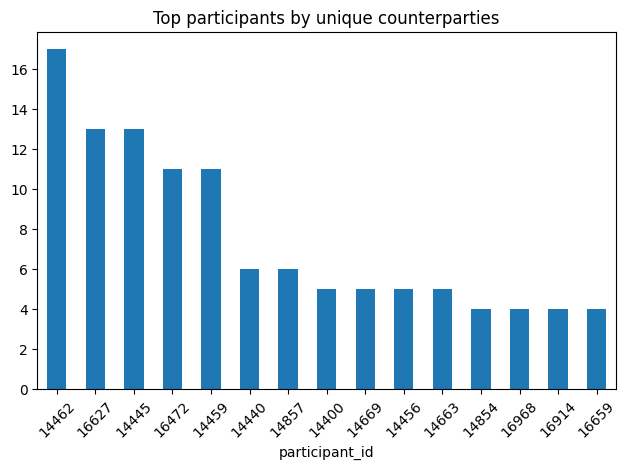

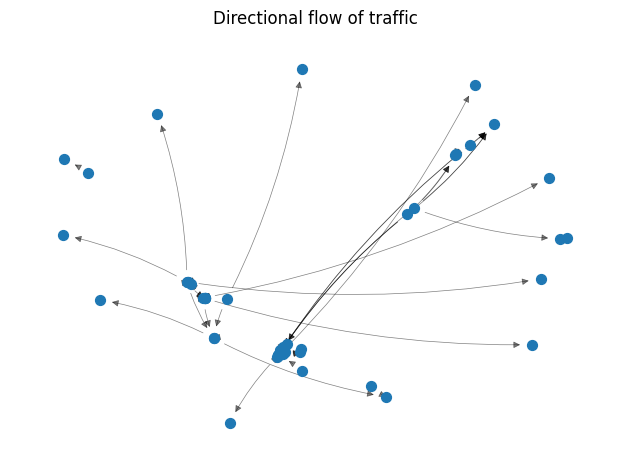

In [8]:
bar_top_series(top_p, 'participant_id', 'unique_counterparties', top_n=15,
               title='Top participants by unique counterparties')
plt.show()
plot_network(flow_pairs.sample(min(len(flow_pairs), 500), random_state=42))

## 2) Outside the Network — Fuzzy standardisation

In [51]:
# Deposits (Remitters)
deposits_df.columns

Index(['deposit_id', 'account_id', 'london_value_date', 'currency', 'amount',
       'normalised_amount', 'deposit_origin', 'deposit_remitter_name',
       'deposit_fee_normalised'],
      dtype='object')

In [52]:
# Deposits (Remitters)
deposits_std = standardise_counterparty_names(deposits_df, col="deposit_remitter_name", threshold=0.9)

In [53]:
deposits_std.head()

,deposit_id,account_id,london_value_date,currency,amount,normalised_amount,deposit_origin,deposit_remitter_name,deposit_fee_normalised,deposit_remitter_name_standardised
0,291106,16472,2025-02-03 14:48:25.627,USD,440000.0,356259.574,US,Remitter 18,204.041789,Remitter 18
1,281968,16472,2025-01-02 09:51:12.963,GBP,440000.0,440000.000,GB,Remitter 8,262.600000,Remitter 18
2,286005,16472,2025-01-16 11:30:19.040,GBP,160000.0,160000.000,GB,Remitter 8,51.000000,Remitter 18
3,314361,16627,2025-04-23 09:15:33.817,GBP,6000.0,6000.000,GB,Afriex Global Remit,29.400000,Afriex Global Remit
4,316521,16627,2025-04-30 08:44:19.117,GBP,24000.0,24000.000,GB,Afriex Global Remit,29.400000,Afriex Global Remit


In [54]:
remitter_flows = aggregate_flows(deposits_std, entity_col="deposit_remitter_name_standardised", amount_col="normalised_amount")
remitter_flows.head(10)

,entity,amount
0,Flutterwave Ltd,5.844396e+08
1,Paystack Nigeria Ltd,2.077539e+08
2,Interswitch Ltd,1.234269e+08
3,Mpesa Safaricom,5.779108e+07
4,Flutter Wave Ng,5.260893e+07
5,Dpogroup Ltd,5.045639e+07
6,M Pesa Kenya Ltd,4.345047e+07
7,Nsano Gh Ltd,4.018284e+07
8,Nsano Accra,3.841823e+07
9,Flwave Lagos,3.470694e+07


In [55]:
# Withdrawals (Beneficiaries)
withdrawals_df.columns

Index(['withdrawal_id', 'account_id', 'london_value_date', 'currency',
       'amount', 'normalised_amount', 'beneficiary_bank_country',
       'beneficiary_name', 'withdrawal_fee_normalised'],
      dtype='object')

In [56]:
# Withdrawals (Beneficiaries)
withdrawals_std = standardise_counterparty_names(withdrawals_df, col='beneficiary_name') # withdrawals table with standardise_counterparty_names
withdrawals_std.head()

,withdrawal_id,account_id,london_value_date,currency,amount,normalised_amount,beneficiary_bank_country,beneficiary_name,withdrawal_fee_normalised,beneficiary_name_standardised
0,322990,14669,2025-01-20 10:39:55.563,EUR,38350.52769,32472.31098,LT,Beneficiary 3,205.987547,Beneficiary 3
1,336346,14669,2025-03-12 11:33:08.160,EUR,69586.48576,58590.74496,LT,Beneficiary 3,205.901522,Beneficiary 3
2,341195,14669,2025-03-31 10:43:18.706,EUR,19826.49636,16588.23448,LT,Beneficiary 3,206.605492,Beneficiary 3
3,353143,14669,2025-05-15 11:03:38.765,EUR,93023.91229,78425.84394,LT,Beneficiary 3,206.124907,Beneficiary 3
4,364051,14669,2025-06-24 12:52:33.569,EUR,52467.08225,44729.86980,LT,Beneficiary 3,206.434820,Beneficiary 3


In [57]:
beneficiary_flows = aggregate_flows(withdrawals_std, entity_col="beneficiary_name_standardised",amount_col="normalised_amount")
beneficiary_flows.head(10)

,entity,amount
0,Bitstamp Europe S A,5.595569e+08
1,Kraken Europe Ltd,3.215426e+08
2,Beneficiary 3,2.917175e+08
3,Coinbase Europe Ltd,1.648157e+08
4,Pax Os Eu,9.606582e+07
5,Company 3,7.700072e+07
6,Bit Stamp Lux,7.415377e+07
7,Bitpanda Gmbh,7.037467e+07
8,Paxos Europe Ltd,5.961942e+07
9,Kraken Fin De,5.225063e+07


<Figure size 640x480 with 0 Axes>

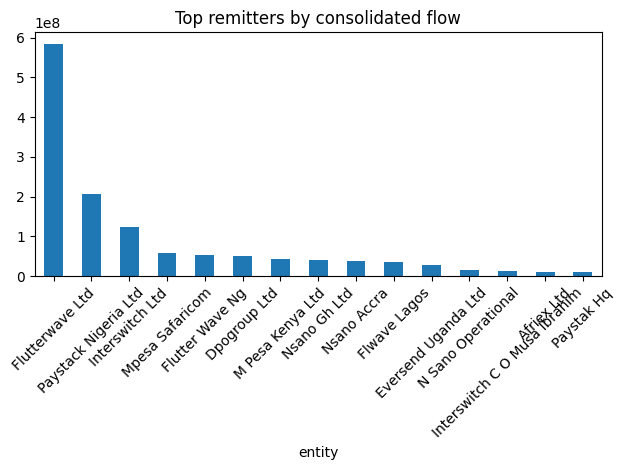

<Figure size 640x480 with 0 Axes>

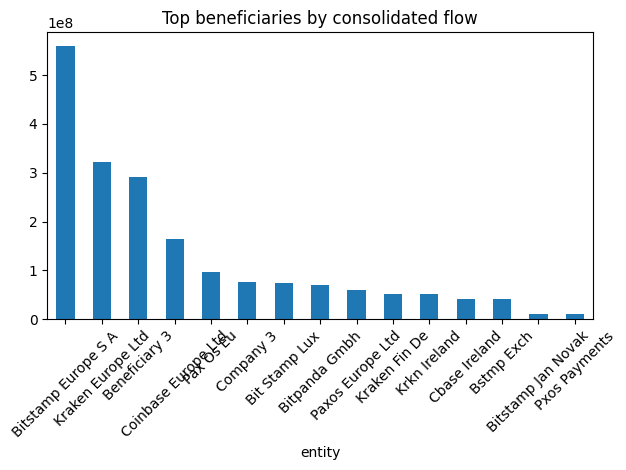

In [58]:
bar_top_series(remitter_flows, 'entity', 'amount', 15, title='Top remitters by consolidated flow')
plt.show()
bar_top_series(beneficiary_flows, 'entity', 'amount', 15, title='Top beneficiaries by consolidated flow')
plt.show()

### Notes
- *Hubs* are clients with high in- and out-degree; *Brokers* show asymmetry; *Peripheral Members* have minimal connections.
- Fuzzy grouping uses character-level normalization + SequenceMatcher with a high threshold (0.9) to be conservative.